In [14]:
import numpy as np
import matplotlib.pyplot as plt
from evalf import evalf
from trapezoidalMatrixFree import trapezoidalMatrixFree
from trapezoidal import rk_integrator, expand_params
from implicit_trap import trapezoidal
from euler import euler
from jacobian import calc_jac
import time


%load_ext autoreload
%autoreload 2

def better_imshow(row_vals, col_vals, data, ax=None):
    #row_vals and col_vals are the data that was swept over
    assert len(row_vals) == data.shape[0], 'length of row_vals does not match shape of data'
    assert len(col_vals) == data.shape[1], 'length of col_vals does not match shape of data'
    if ax == None:
        plt.imshow(data, origin='lower', extent=[col_vals[0], col_vals[-1], row_vals[0], row_vals[-1]], aspect='auto')
    else:
        ax.imshow(data, origin='lower', extent=[col_vals[0], col_vals[-1], row_vals[0], row_vals[-1]], aspect='auto')
        
        
def plot_results(x, L_list, tlist):
    n_t = x[:,2:]
    plt.pcolormesh(tlist, 1000*L_list, n_t.T/1000, shading='nearest')
    # plt.contourf(tlist, L_list, n_t.T)
    plt.ylabel(r'Particle size $L$ (mm)')
    plt.xlabel(r'$t$ ($s$)')
    plt.colorbar()
    # plt.title(r'Population density ($m^{-1}$)')
    plt.title(r'Population density (1/mm)')
    plt.show()


    # plt.plot(tlist, x[:,0]) 
    # plt.title('supersaturation')
    # plt.xlabel('t')
    # plt.show()

    # plt.plot(tlist, x[:,1]) 
    # plt.title('volume')
    # plt.xlabel('t')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|          | 0/3000 [00:00<?, ?it/s]

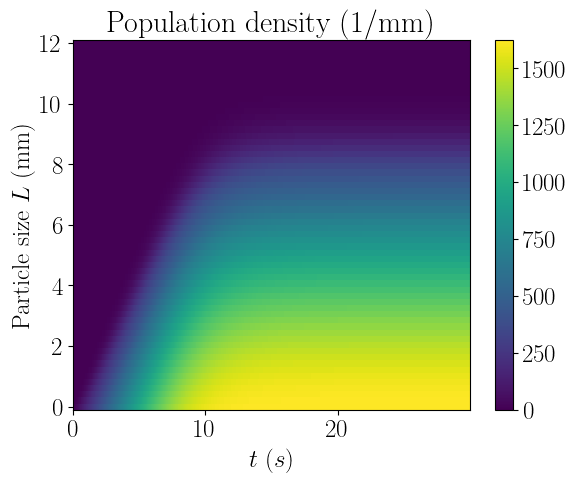

In [20]:
# start by computing a reference with RK4
t_final = 30
L_list = np.linspace(0,1.2e-2,60)

S0 = 1 #initial supersaturation
V0 = 1 #initial volume
n0 = np.zeros_like(L_list) #initial population density distribution
x0 = np.hstack([S0, V0, n0])

p = {"L_list" : L_list, #discretization bins
     'E' :  1e-7, #evaporation rate
     'rho' : 1200, # density of the crystal
     'k_v' : 1, #goes in N_C, volumetric shape factor
     'k_g' : 1e-3, #growth rate constant m/s
     'g' : 1, #power constant for growth
     'k_N' : 1e5, #nucleation rate constant 
     'alpha' :2, #power constant for nucleation
     'weno': False  # use weno or not for differentiation w.r.t. L
     }

p_expand = expand_params(p)

# xlist = []
# for dt in np.logspace(-1, -3, 10):
#     # dt = 1e-1
#     tlist = np.arange(0, t_final, dt)
#     x_t = rk_integrator(x0, tlist, p)
#     xlist.append(x_t[-1,:])

dt = 1e-2
tlist = np.arange(0, t_final, dt)
x_t = rk_integrator(x0, tlist, p)
plot_results(x_t, L_list, tlist)

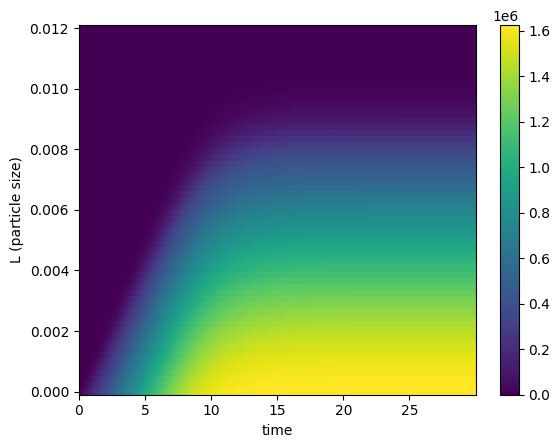

In [3]:
plot_results(x_t, L_list, tlist)

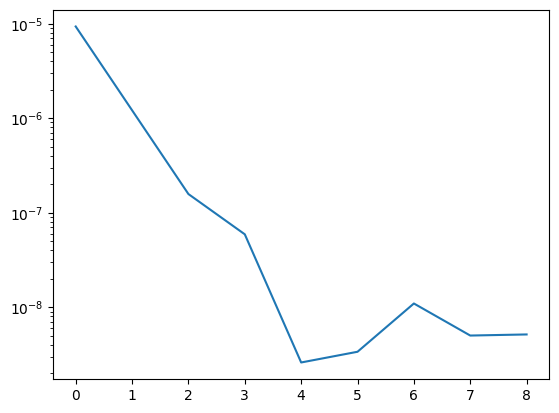

In [4]:
errors = []
for i in range(len(xlist)-1):
    errors.append(np.linalg.norm((xlist[i+1]-xlist[i]))/np.linalg.norm(xlist[i+1]))
    
plt.plot(errors)
plt.yscale('log')

In [5]:
n_ref = xlist[-1][2:]

In [6]:
def calc_error(x_t):
    return np.linalg.norm(x_t[-1,2:] - n_ref)/np.linalg.norm(n_ref)

# Error of 1%

### RK4

In [7]:
dt = 6.495e-1
tlist = np.arange(0, t_final, dt)

niter = 50
start = time.time()
for _ in range(niter):
    x_t = rk_integrator(x0, tlist, p)
stop = time.time()
print('time =',  np.round((stop-start)/niter, 3), 's')


print('error:', np.round(100*calc_error(x_t),3), '%')
print(len(x_t))

time = 0.032 s
error: 0.992 %
47


### Euler

In [413]:
dt = 2e-2
tlist = np.arange(0, t_final, dt)

niter = 10
start = time.time()
for _ in range(niter):
    x_t = euler(x0, tlist, p)
stop = time.time()
print('time =',  np.round((stop-start)/niter, 3), 's')

print('error:', np.round(100*calc_error(x_t),3), '%')
len((x_t))

time = 0.573 s
error: 0.948 %


1500

### implicit (matrix free)

In [9]:
# alpha = [1e-1, 11e-1, 20] #78
alpha = [1e7, 6.5e-3, 20]

# alpha = [1e-1, 100000, 0.4] #77
# alpha = [100, 100000000000000, 0.6495] #too high error

niter = 1
start = time.time()
for _ in range(niter):
    x_t, _ = trapezoidalMatrixFree(
        evalf,
        x0,
        alpha,
        0,
        T=t_final, 
        p=p, 
        errf=1e-2,
        errDeltax=1e-2,
        relDeltax=1e-3,
        MaxIter=40,
        tolrGCR=1e-3,
        epsMF=1e-6)
stop = time.time()
print('time =',  np.round((stop-start)/niter, 3), 's')

x_t = np.array(x_t)
print('error:', np.round(100*calc_error(x_t),3), '%')
print(len(x_t))

time = 0.315 s
error: 0.928 %
39


### implicit (not matrix free...)

In [420]:
alpha = [1e7, 6.5e-3, 20]
f= lambda x: evalf(x,p)

niter = 4
start = time.time()
for _ in range(niter):
    x_t, _ = trapezoidal(
        f,
        x0,
        t_start=0,
        t_end=t_final,
        alpha=alpha,
        jf= lambda x: calc_jac(x, p, eps=1e-8),
        e_f =1e-2,
        e_delta_x=1e-2,
        e_x_rel=1e-2,
        maxiter=100)
stop = time.time()
print('time =',  np.round((stop-start)/niter, 3), 's')

x_t = np.array(x_t)
print('error:', np.round(100*calc_error(x_t),3), '%')
print(len(x_t))

time = 2.456 s
error: 0.928 %
39


# Error of 0.1%

### RK4

In [422]:
dt = 3.35e-1
tlist = np.arange(0, t_final, dt)

niter = 20
start = time.time()
for _ in range(niter):
    x_t = rk_integrator(x0, tlist, p)
stop = time.time()
print('time =',  np.round((stop-start)/niter, 3), 's')

print('error:', np.round(100*calc_error(x_t),3), '%')
print(len(x_t))

time = 0.063 s
error: 0.098 %
90


### Euler

In [423]:
dt = 2.4e-3
tlist = np.arange(0, t_final, dt)

niter = 3
start = time.time()
for _ in range(niter):
    x_t = euler(x0, tlist, p)
stop = time.time()
print('time =',  np.round((stop-start)/niter, 3), 's')

print('error:', np.round(100*calc_error(x_t),3), '%')
print(len(x_t))

time = 4.401 s
error: 0.097 %
12501


### implicit (matrix free)

In [10]:
alpha = [1e8, 1.449e-4, 20] # 162
# alpha = [1e5, 5e-2, 20]
# alpha = [1e7, 2.2e99, 0.1] # 301

niter = 1
start = time.time()
for _ in range(niter):
    x_t, _ = trapezoidalMatrixFree(
        evalf,
        x0,
        alpha,
        0,
        T=t_final, 
        p=p, 
        errf=1e-2,
        errDeltax=1e-2,
        relDeltax=1e-3,
        MaxIter=40,
        tolrGCR=1e-3,
        epsMF=1e-6)
stop = time.time()
print('time =',  np.round((stop-start)/niter, 3), 's')

x_t = np.array(x_t)
print('error:', np.round(100*calc_error(x_t),3), '%')
print(len(x_t))

time = 0.683 s
error: 0.093 %
162


### implicit (not matrix free...)

In [426]:
alpha = [1e8, 1.449e-4, 20] # 162

f= lambda x: evalf(x,p)


niter = 2
start = time.time()
for _ in range(niter):
    x_t, _ = trapezoidal(
        f,
        x0,
        t_start=0,
        t_end=t_final,
        alpha=alpha,
        jf= lambda x: calc_jac(x, p, eps=1e-8),
        e_f =1e-2,
        e_delta_x=1e-2,
        e_x_rel=1e-2,
        maxiter=100)
stop = time.time()
print('time =',  np.round((stop-start)/niter, 3), 's')

x_t = np.array(x_t)
print('error:', np.round(100*calc_error(x_t),3), '%')
print(len(x_t))

time = 8.788 s
error: 0.093 %
162


# Error of 0.01%

### RK4

In [428]:
dt = 1.75e-1
tlist = np.arange(0, t_final, dt)

niter = 30
start = time.time()
for _ in range(niter):
    x_t = rk_integrator(x0, tlist, p)
stop = time.time()
print('time =',  np.round((stop-start)/niter, 3), 's')

print('error:', np.round(100*calc_error(x_t),3), '%')
print(len(x_t))

time = 0.125 s
error: 0.01 %
172


### Euler

In [430]:
dt = 2.5e-4
tlist = np.arange(0, t_final, dt)

niter = 2
start = time.time()
for _ in range(niter):  
    x_t = euler(x0, tlist, p)
stop = time.time()
print('time =',  np.round((stop-start)/niter, 3), 's')

print('error:', np.round(100*calc_error(x_t),3), '%')
print(len(x_t))

time = 42.694 s
error: 0.01 %
120000


### implicit (matrix free)

In [11]:
alpha = [1e8, 4.1e-5, 20]  # 561

niter = 1
start = time.time()
for _ in range(niter):  
    x_t, _ = trapezoidalMatrixFree(
        evalf,
        x0,
        alpha,
        0,
        T=t_final, 
        p=p, 
        errf=1e-2,
        errDeltax=1e-2,
        relDeltax=1e-3,
        MaxIter=40,
        tolrGCR=1e-3,
        epsMF=1e-6)
stop = time.time()
print('time =',  np.round((stop-start)/niter, 3), 's')

x_t = np.array(x_t)
print('error:', np.round(100*calc_error(x_t),3), '%')
print(len(x_t))

time = 1.63 s
error: 0.006 %
561


### implicit (not matrix free...)

In [432]:
alpha = [1e8, 4.1e-5, 20]  # 561

f= lambda x: evalf(x,p)

niter = 2
start = time.time()
for _ in range(niter):  
    x_t, _ = trapezoidal(
        f,
        x0,
        t_start=0,
        t_end=t_final,
        alpha=alpha,
        jf= lambda x: calc_jac(x, p, eps=1e-8),
        e_f =1e-2,
        e_delta_x=1e-2,
        e_x_rel=1e-2,
        maxiter=100)
stop = time.time()
print('time =',  np.round((stop-start)/niter, 3), 's')

x_t = np.array(x_t)
print('error:', np.round(100*calc_error(x_t),3), '%')
print(len(x_t))

time = 25.76 s
error: 0.006 %
561


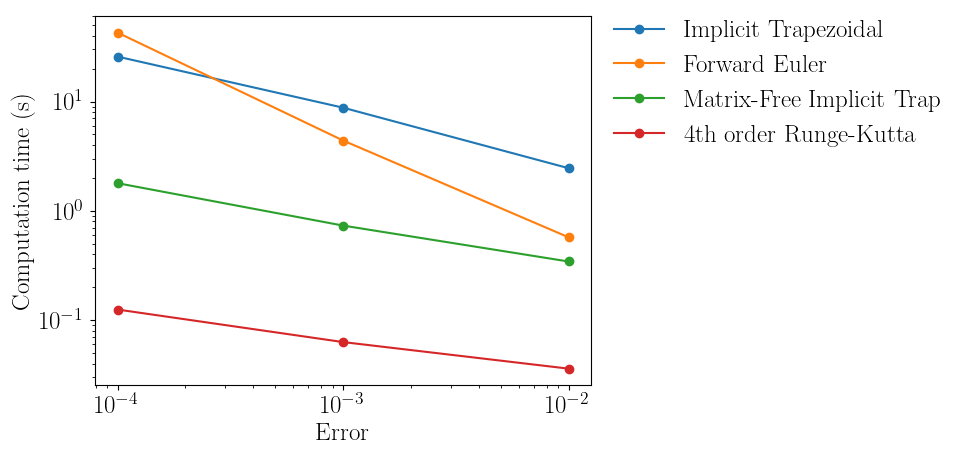

In [12]:
RK4_times = [0.036, 0.063, 0.125]
euler_times = [0.573, 4.401, 42.694]
matrixfree_trap_times = [0.344, 0.733, 1.79]
trap_times = [2.456, 8.788, 25.76]


errors = np.array([1, 0.1, 0.01])/100
accuracy = 1-errors

import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rcParams.update({'font.family': 'Times New Roman'})
matplotlib.rcParams.update({'axes.labelsize': 18})

plt.plot(errors, trap_times, 'o-', label = 'Implicit Trapezoidal')
plt.plot(errors, euler_times, 'o-', label='Forward Euler')
plt.plot(errors, matrixfree_trap_times, 'o-', label='Matrix-Free Implicit Trap')
plt.plot(errors, RK4_times, 'o-', label='4th order Runge-Kutta')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Error')
plt.ylabel('Computation time (s)')
plt.legend(frameon=False, bbox_to_anchor=(1,1.05))
plt.savefig('time_vs_error.jpg', dpi=300, bbox_inches='tight')